# Pennylane - wprowadzenie

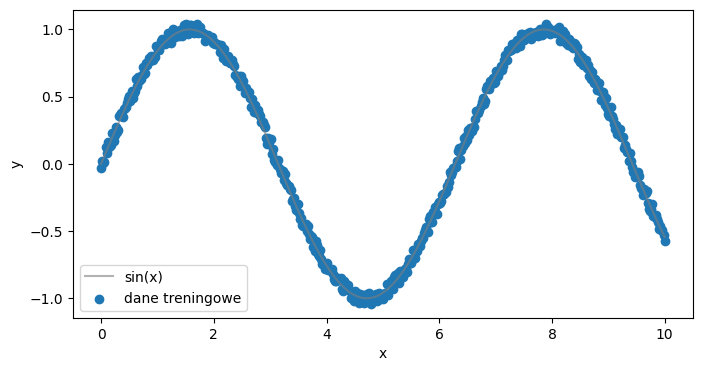

In [1]:
import torch
import matplotlib.pyplot as plt 
from IPython.display import clear_output


x = torch.linspace(0,10,500).view(-1,1)

si = torch.sin(x).view(-1,1)

y = si + 0.1*(torch.rand(500).view(-1,1)-0.5)


plt.figure(figsize=(8,4))
plt.plot(x, torch.sin(x).view(-1,1), color="tab:grey", alpha=0.6, label="sin(x)")
plt.scatter(x, y, label="dane treningowe")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [2]:
class QN(torch.nn.Module):
    '''Classical -> Quantum -> Classical'''

    def __init__(self, N_INPUT: int, N_OUTPUT: int, Q_NODE, N_QUBITS):
        super().__init__()

        self.layers = torch.nn.Sequential(
            # input layer
            torch.nn.Linear(N_INPUT, N_QUBITS),
            # 1st hidden layer as a quantum circuit
            Q_NODE,
            # output layer
            torch.nn.Linear(N_QUBITS, N_OUTPUT)
        )
        

    def forward(self, x):
        return  self.layers(x)

In [3]:
import pennylane as qml

n_qubits = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 3

weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [4]:
qmodel = QN(1, 1, qlayer, n_qubits)

learning_rate=1e-3

optimiser = torch.optim.Adam(qmodel.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

losses = []

In [5]:
def callback(model, loss):
    losses.append(loss.item())

    clear_output(wait=True)
    prediction = model(x).detach()
    plt.figure(figsize=(6,2.5))
    plt.plot(x[:,0].detach(), torch.sin(x)[:,0].detach(), label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(x[:,0].detach(), prediction[:,0], label="Classical solution", color="tab:green")
    plt.title(f"Training step {len(losses)}")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,2.5))
    plt.title('Lossfn Visualised')
    plt.plot(losses)
    plt.show()


def train(X, Y, model, optimiser, epochs, lossfn, callback = None):
    for _ in range(epochs):
        model.train()
        prediction = model(X)
        loss = lossfn(prediction, Y)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        model.eval()
        if callback != None:
            callback(model, loss)

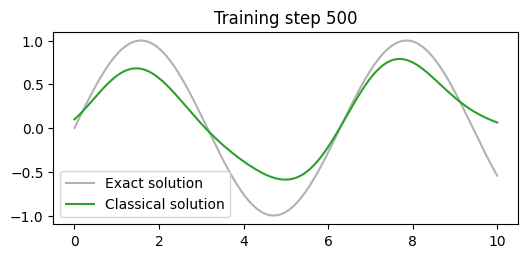

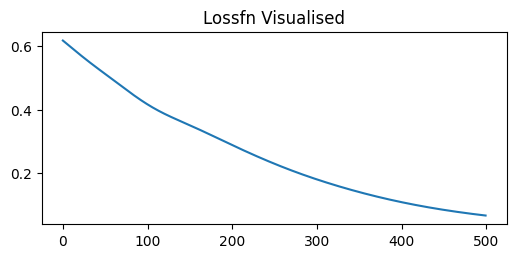

In [6]:
train(x, y, qmodel, optimiser,500, criterion, callback)

## 🧠 PennyLane

🔗 **[Strona oficjalna](https://pennylane.ai)**  

**PennyLane** to otwarto‑źródłowa biblioteka Pythona opracowana przez **Xanadu** dla **kwantowego uczenia maszynowego**, **obliczeń kwantowych** oraz **chemii kwantowej**.  

Zapewnia wysokopoziomowy, intuicyjny interfejs do budowania **hybrydowych modeli kwantowo‑klasycznych**, łącząc obwody kwantowe z popularnymi frameworkami uczenia maszynowego, takimi jak **PyTorch** i **TensorFlow**.

PennyLane wprowadza pojęcie **QNode** (quantum node) – funkcji kwantowych, które zachowują się jak zwykłe funkcje Pythona i obsługują automatyczną różniczkowanie (autodiff).  

Umożliwia uruchamianie modeli zarówno na **symulatorach**, jak i na **rzeczywistym sprzęcie kwantowym** (np. IBM Q, Amazon Braket i inne).

Dzięki PennyLane możesz:
- budować **wariacyjne algorytmy kwantowe**,  
- trenować **kwantowe sieci neuronowe**,  
- eksplorować zaawansowane architektury kwantowego uczenia maszynowego.  

Biblioteka stanowi potężny most między klasyczną sztuczną inteligencją a rosnącym światem obliczeń kwantowych.

PennyLane zawiera także spersonalizowaną wersję **NumPy** (`pennylane.numpy`), która obsługuje **tablice śledzone gradientem**, co ułatwia integrowanie obwodów kwantowych w procesach optymalizacji.


![PennyLane](../img/pennylane.png)


## podstawowe importy bibliotek

In [ ]:
import pennylane as qml
import pennylane.numpy as np

### 🧪 Obwody kwantowe w PennyLane

- Obwody kwantowe są implementowane jako **funkcje kwantowe**, zwane także **QNode’ami**.  
  Są to funkcje kwantowe zachowujące się jak standardowe funkcje Pythona i wspierające automatyczną różniczkację przy użyciu klasycznych narzędzi ML.

- QNode’y są uruchamiane na różnych **urządzeniach** (devices), takich jak:

  - **symulatory** (np. `default.qubit`, `lightning.qubit`) oraz,
  - **rzeczywisty sprzęt kwantowy** (np. IBM Q, Amazon Braket, Xanadu).

- Urządzenia są wymienne i określają, w jaki sposób dana funkcja kwantowa jest wykonywana.



![PennyLane](../img/pennylane1.jpg)

🔗 **[Urządzenia, które możesz używać](https://pennylane.ai/devices)**  

Możemy zdefiniować nasz symulator — w tym przypadku użyjemy `default.qubit`.  
Musimy także określić, ile **kubitów** chcemy użyć, korzystając z parametru `wires`.

**Przykładowe urządzenia**

- `default.qubit` – symulator napisany w Pythonie  
- `lightning.qubit` – szybszy symulator napisany w C++  
- `default.mixed` – używany do symulacji **mieszanych stanów kwantowych**

In [13]:
dev = qml.device("default.qubit", wires=1)

In [14]:
## for example 
dev2 = qml.device("default.qubit", wires=3)

dev3 = qml.device("lightning.qubit", wires=['q1', 'aux'])

![kubity1](../img/kubity1.jpg)

$$
\ket{000} = \ket{0}\otimes \ket{0} \otimes \ket{0}
$$

<img src="../img/Qnode.png" />

Obiekt `Qnode` będziemy używać do definicji obwodów kwantowych.
Obiekt ten wspiera wiele bibliotek do obliczeń numerycznych, tzw. interfejsów: 
- `NumPy`, 
- `PyTorch`, 
- `TensorFlow`,
- `JAX`

Domyślnie `QNodes` używa interfejs `NumPy`. Dzięki niemu mamy dostęp do optymalizatorów domyślnych z biblioteki Pennylane. Pozostałe interferjsy wymagają użycia optymalizatorów z innych pakietów. 

In [15]:
def qc(): # quantum circuit
    return qml.state()

wires oznacza kwantowy podsystem - czyli nasz pojedynczy kubit. Liczymy od 0 nie od 1. 

- Funkcja kwantowa może pobierać klasyczne pamaretry 
- Funkcja kwantowa może zawierać klasyczny flow (przepływ) twojego programu `for` czy `if else`.

Zbiór [kwantowych operatorów](https://docs.pennylane.ai/en/stable/introduction/operations.html) 

## Uruchomienie obwodu kwantowego 

Uruchomienie odbywa się po wyborze `device` z określeniem ilości kubitów (wires)

In [16]:
circ = qml.QNode(qc, dev)
circ()

array([1.+0.j, 0.+0.j])

$$
\ket{\psi} = \ket{0} = [1,0]^{T}
$$

In [17]:
circ2 = qml.QNode(qc, dev2)
circ2()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [18]:
circ3 = qml.QNode(qc, dev3)
circ3()

array([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [19]:
dev = qml.device("default.qubit", wires=1)

def quantum_circuit():
    qml.Hadamard(wires=0)
    return qml.state()

circ = qml.QNode(quantum_circuit, dev)

circ()

array([0.70710678+0.j, 0.70710678+0.j])

In [20]:
from math import sqrt
print(circ()[0].real, 1/sqrt(2))
print(circ()[0].real == 1/sqrt(2))

0.7071067811865475 0.7071067811865475
True


In [21]:
qml.draw(circ)()

'0: ──H─┤  State'

(<Figure size 400x200 with 1 Axes>, <Axes: >)

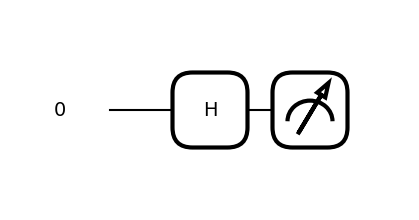

In [22]:
qml.draw_mpl(circ)()

## obwody z wykorzystaniem decoratora `@qml.qnode()`

In [23]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.state()

qc()

array([0.70710678+0.j, 0.70710678+0.j])

Matplotlib is building the font cache; this may take a moment.


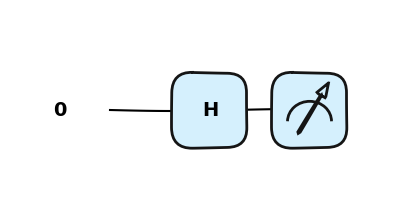

In [24]:
import matplotlib.pyplot as plt

qml.drawer.use_style("pennylane_sketch")

fig, ax = qml.draw_mpl(qc)()
plt.show()

- `qml.probs()`

In [25]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.probs()

qc()

array([0.5, 0.5])

a jaki wynik otrzymamy dla pustego obwodu? 

In [26]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    return qml.probs()

results = qc()
results

array([1., 0.])

- użyj `qml.sample()` lub `qml.counts()`  dla innych wariantów wyników. 

Ilość wykonań obwodu sterowana jest w QNode za pomocą parametru `shot`, który może być liczbą jak również listą liczb. 
> Uwaga w wersji biblioteki <0.43 - parametr shot ustawiany jest na poziomie device.

In [29]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, shots=5)
def qc():
    qml.Hadamard(wires=0)
    return qml.sample()

qc()

array([[0],
       [0],
       [0],
       [0],
       [1]])

In [30]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, shots=100)
def qc():
    qml.Hadamard(wires=0)
    return qml.counts()

results = qc()

In [31]:
results

{np.str_('0'): np.int64(48), np.str_('1'): np.int64(52)}

In [32]:
type(results), results.items()

(dict,
 dict_items([(np.str_('0'), np.int64(48)), (np.str_('1'), np.int64(52))]))

In [33]:
int(results['0']), int(results['1'])

(48, 52)

In [38]:
from functools import partial

dev = qml.device("default.qubit", wires=['q1'])

@partial(qml.set_shots, shots=[5, 10, 1000])
@qml.qnode(dev)
def qc():
    qml.Hadamard(wires='q1')
    return qml.counts()

results = qc()

In [39]:
results

({np.str_('0'): np.int64(3), np.str_('1'): np.int64(2)},
 {np.str_('0'): np.int64(6), np.str_('1'): np.int64(4)},
 {np.str_('0'): np.int64(520), np.str_('1'): np.int64(480)})

## Przygotowanie własnego stanu początkowego 

$$
\ket{\psi}=\ket{1} = 0 \ket{0} + 1 \ket{1}
$$

In [40]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.ops import StatePrep

dev = qml.device("default.qubit", wires=1)


state1 = np.array([0,1]) # state after initialization 

@qml.qnode(dev)
def qc(state):
    StatePrep(state, wires=0)
    return qml.state()

qc(state1).real

tensor([0., 1.], requires_grad=True)

In [41]:
@qml.qnode(dev)
def qc(state):
    StatePrep(state, wires=0)
    return qml.probs()

qc(state1)

tensor([0., 1.], requires_grad=True)

dwa kubity 

In [42]:
dev = qml.device("default.qubit", wires=2)

stan = np.array([1/2, 1/2, 1/2, 1/2])

prawd = [i**2 for i in stan]
print(f"test: sum of probs {np.sum(prawd)}")

@qml.qnode(dev)
def qc():
    StatePrep(stan, wires=[0,1])
    return qml.state()

qc()

test: sum of probs 1.0


tensor([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j], requires_grad=True)


Kod naszej wartwy ukrytej w której użyliśmy obwodu kwantowego realizował następujące obiekty i funkcje:
```python

import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]
```


`Obwody kwantowe` składają się z rejestrów, które reprezentują poszczególne kubity.

![](../img/kubity1.jpg)

`Domyślnie kubity inicjalizujemy w stanie 0.`

![](../img/kubity2.jpg)



Operacje wykonywane na kubitach nazywamy bramkami.

Operacje te można wykonywać na jednym albo i wielu kubitach na raz.

Domyślnie będziemy optymalizować algortymy aby składały się z jak najmniejszej ilości bramek działających na dużą liczbę kubitów. 


Graficznie można rozumieć realizację algorytmu jako stosowanie bramek na poszczególnych kubitach.

![kibu2](../img/obwod1.png)



W bibliotece PennyLane, `obwody kwantowe` reprezentowane są przez `kwantowe funkcje`, realizowane przez klasyczne funkcje w pythonie. 

Schemat kodu penny lane możemy zapisać jako: 

```python
import pennylane as qml

def my_quantum_function(params):

    # Single-qubit operations with no input parameters
    qml.Gate1(wires=0)
    qml.Gate2(wires=1)

    # A single-qubit operation with an input parameter
    qml.Gate3(params[0], wires=0)

    # Two-qubit operation with no input parameter on wires 0 and 1
    qml.TwoQubitGate1(wires=[0, 1])

    # Two-qubit operation with an input parameter on wires 0 and 1
    qml.TwoQubitGate2(params[1], wires=[0, 1])

    # Return the result of a measurement
    return qml.Measurement(wires=[0, 1])
```
Matematycznie całość możemy zapisać jako: 

![](../img/stanpennylane.png)


Przykładowo

![](../img/przyklad1.png)



In [43]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=2)
#dev = qml.device("default.qubit", wires=2, shots=1000)

@qml.qnode(dev)
def circ(theta):
    qml.Hadamard(wires = 0)
    qml.CNOT(wires = [0,1])
    qml.RZ(theta, wires = 0)
    return qml.state()
#    return qml.probs(wires = [0,1])

circ(np.pi)

array([4.32978028e-17-0.70710678j, 0.00000000e+00+0.j        ,
       0.00000000e+00+0.j        , 4.32978028e-17+0.70710678j])

In [44]:
print(qml.draw(circ)(np.pi))

0: ──H─╭●──RZ(3.14)─┤  State
1: ────╰X───────────┤  State


(<Figure size 600x300 with 1 Axes>, <Axes: >)

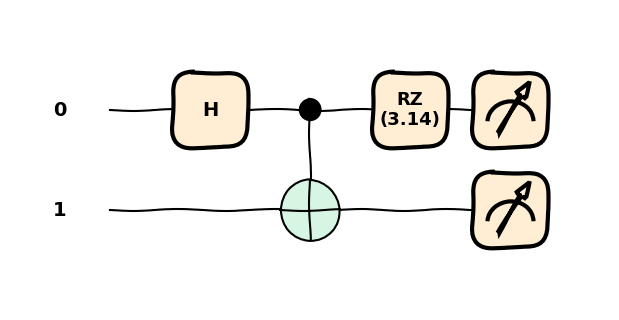

In [46]:
qml.draw_mpl(circ, decimals=2, style="sketch", level="device")(np.pi)

### Bramka X

Bramka X-gate reprezentowana jest przez macierz Pauli-X : 

$$
X = \begin{pmatrix}
0 & 1 \\
1 & 0 \\
\end{pmatrix}
$$


Bramka X obraca kubit w kierunku osi na sferze Bloch'a o $\pi$ radianów.
Zmienia $|0\rangle$ na $|1\rangle$ oraz $|1\rangle$ na $|0\rangle$.
Jest często nazywana kwantowym odpowiednikiem bramki NOT lub określana jako `bit-flip`.

$$ \sigma_x \ket{0} = \ket{1} \,\,\, \sigma_x\ket{1} = \ket{0} $$

In [47]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.X(wires=0)
    return qml.state()

qc()

array([0.+0.j, 1.+0.j])

In [48]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.PauliX(wires=0)
    return qml.state()

qc()

array([0.+0.j, 1.+0.j])

(<Figure size 400x200 with 1 Axes>, <Axes: >)

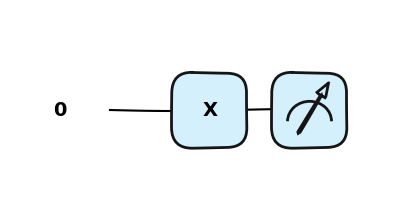

In [49]:
qml.draw_mpl(qc)()

array([1.+0.j, 0.+0.j])

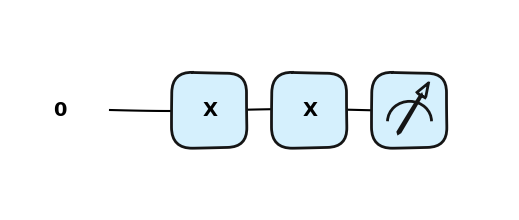

In [50]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.PauliX(wires=0)
    qml.X(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### Dowolna bramka unitarna


tensor([0.70710678+0.j, 0.70710678+0.j], requires_grad=True)

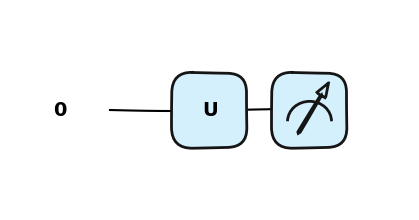

In [51]:
from pennylane import numpy as np

U = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.QubitUnitary(U, wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### Bramka Hadamarda 
Bramka Hadamarda przetwarza stan $|0\rangle$ na kombinacje liniowa (superpozycje) $\frac{|0\rangle + |1\rangle}{\sqrt{2}}$, co oznacza, że pomiar zwróci z takim samym prawdopodobieństwem stanu `1` lub `0`. 
Stan ten często oznaczany jest jako: $|+\rangle$. 

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1 \\
1 & -1 \\
\end{pmatrix}
$$

$$ H\ket{0} = \frac{\sqrt{2}}{2} (\ket{0}+ \ket{1})$$
$$ H\ket{1} = \frac{\sqrt{2}}{2}(\ket{0}- \ket{1})$$

In [52]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc():
    qml.Hadamard(wires=0)
    return qml.state()

qc()

array([0.70710678+0.j, 0.70710678+0.j])

In [53]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qc(state):
    if state==1:
        qml.X(wires=0)
    qml.Hadamard(wires=0)
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)
    return qml.state()

qc(0)

array([1.+0.j, 0.+0.j])

In [54]:
qc(1)

array([ 0.+0.j, -1.+0.j])

### bramka SX

Bramka SX jest pierwiastkiem kwadratowym bramki X. Dwukrotne zastosowanie powinno reazlizowac bramkę X.

$$
SX = \frac{1}{2}\begin{pmatrix}
1+i & 1-i \\
1-i & 1+i \\
\end{pmatrix}
$$


array([0.5+0.5j, 0.5-0.5j])

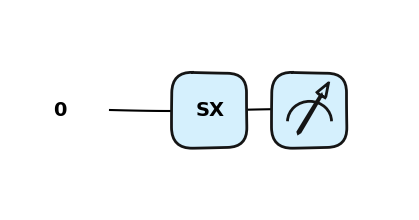

In [55]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.SX(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

array([0.+0.j, 1.+0.j])

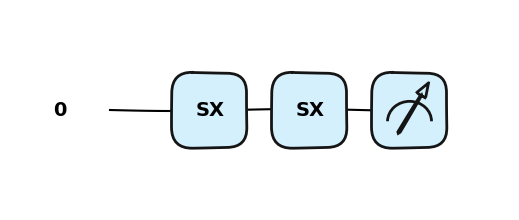

In [56]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.SX(wires=0)
    qml.SX(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### Z gate

$$
Z = \begin{pmatrix}
1 & 0 \\
0 & -1 \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \pi} \\
\end{pmatrix}
$$

Inne nazwy bramki: `phase flip` lub `sign flip`

array([ 1.+0.j, -0.+0.j])

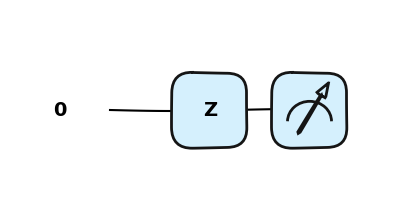

In [57]:
dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)
def qc():
    qml.Z(wires=0)
    return qml.state()

qml.draw_mpl(qc)()
qc()

### RZ gate

Bramkę PauliZ można uogólnić i sparametryzować kątem. Dla $\phi=\pi$ otrzymujemy bramkę $\sigma_z$. 

$$
\begin{pmatrix}
1 & 0 \\
0 & -1 \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \pi} \\
\end{pmatrix} = \begin{pmatrix}
1 & 0 \\
0 & e^{i \phi} \\
\end{pmatrix}
$$


$$ R_Z(\phi) = e^{-i \phi \frac{\sigma_z}{2} }  $$

$$
RZ = \begin{pmatrix}
e ^{-i \frac{\phi}{2} } & 0 \\
0 & e ^{i \frac{\phi}{2} } \\
\end{pmatrix} = \cos(\frac{\phi}{2})I_2 - \sin(\frac{\phi}{2}) i\sigma_z
$$

In [58]:
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)


def qc(phi):
    qml.RZ(phi=phi, wires=0)
    return qml.state()

qc(np.pi/2)

array([0.70710678-0.70710678j, 0.        +0.j        ])

(<Figure size 400x200 with 1 Axes>, <Axes: >)

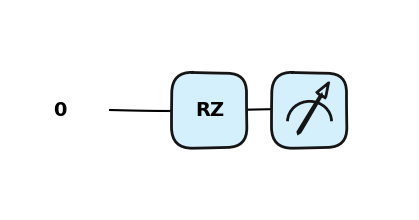

In [59]:
qml.draw_mpl(qc)(np.pi/2)

In [60]:
from pennylane import numpy as np

dev = qml.device("default.qubit", wires=1)
@qml.qnode(dev)


def qc(phi):
    qml.SX(wires=0)
    qml.RZ(phi=phi, wires=0)
    return qml.state()

qc(np.pi)

array([0.5-0.5j, 0.5+0.5j])